In [1]:
# - compatibility with Python 3
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0

In [2]:
# - show figures inside the notebook
%matplotlib inline

In [3]:
# - import common modules
import numpy as np  # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

In [4]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [5]:
# - nibabel package
import nibabel as nib

In [6]:
# - our rotations module
import sys
import os
sys.path.append(os.path.join('..', 'for_exercises'))
from rotations import x_rotmat, y_rotmat, z_rotmat

## An affine normalization

In the last notebook - [moreon_rotation](moreon_rotation.ipynb) - we undid a rotation.

In that case, I told you what the rotation was.  What if I didn't tell you?  Could you work it out?

This is a good job for optimization.

In [7]:
# - the first volume of ds107_sub012_t1r2.nii
img_4d = nib.load('ds107_sub012_t1r2.nii')
data = img_4d.get_data()
vol0 = data[..., 0]

Here is the volume with some secret rotations:

In [8]:
# - the secretly rotated image
rotated_img = nib.load('secret_rotated_volume.nii')
rotated_vol0 = rotated_img.get_data()
rotated_vol0.shape

(64, 64, 35)

Displayed side by side with the original (not-rotated) image:

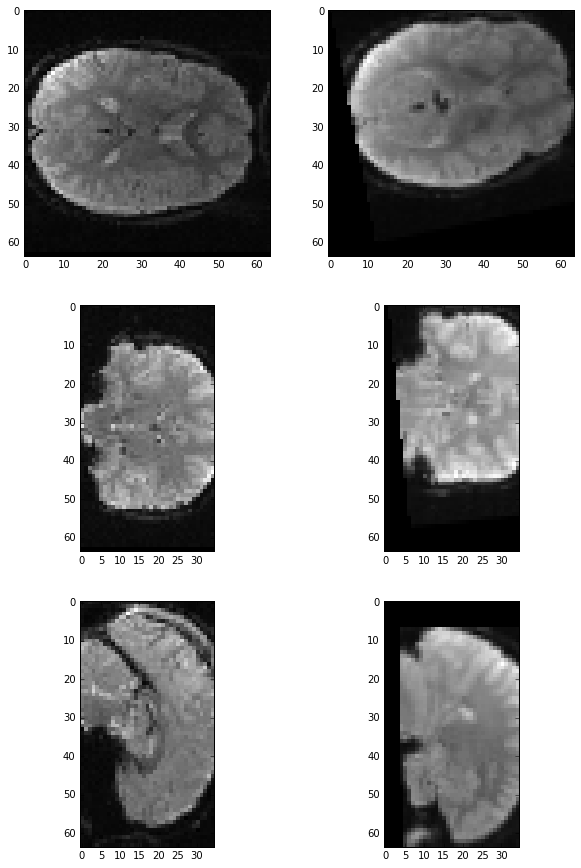

In [9]:
# - slices on z, y, and x axis from 
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes[0, 0].imshow(vol0[:, :, 17])
axes[0, 1].imshow(rotated_vol0[:, :, 17])
axes[1, 0].imshow(vol0[:, 31, :])
axes[1, 1].imshow(rotated_vol0[:, 31, :])
axes[2, 0].imshow(vol0[31, :, :])
axes[2, 1].imshow(rotated_vol0[31, :, :])

You might be able to work out what the transformations are, at least roughly, but can we work them out by optimization?

The first thing we need for optimization, is a mismatch metric.

I suggest you use the correlation mismatch function for the metric.  You can get that from the [optimizing_space](optimizing_space.ipynb) notebook, and paste it below.  But feel free to try another mismatch metric if you like.  Remember it is a function that accepts two images and returns a scalar that is low when the images are well matched.

In [10]:
# Get the correlation mismatch metric from `optimizing_space`, paste here
def correl_mismatch(slice0, slice1):
    """ Negative correlation between the two images, flattened to 1D """
    correl = np.corrcoef(slice0.ravel(), slice1.ravel())[0, 1]
    return -correl

Now we need a function that will transform a given image by a given set of rotations.  The arguments will be:

* `vol_arr` : the image that we will transform;
* `rotations` - a vector of rotations.

The function then returns a copy of `vol_arr` with those rotations applied.

Specifically, the `rotations` give the *resampling transform* that gives the mapping from coordinates in a new empty copy of `vol_arr` - call this `K` - to coordinates in `vol_arr`.

Our vector of rotations is length 3, containing the $r_x, r_y, r_z$, which are, respectively, the rotations about the x, y and z axis.

In order to do this transformation, you will need to take the three parameters, and convert them to the corresponding rotation matrix.

You then need to apply this transformation matrix to the coordinates of `K` to return a new copy of `vol_arr` with $r_x, r_y, r_z$ applied.  Of course, this will be a job for `affine_transform`:

In [11]:
from scipy.ndimage import affine_transform

Your new function will look something like this:

```
def apply_rotations(vol_arr, rotations):
    r_x, r_y, r_z = rotations
    rotation_matrix = ?
    # apply rotations with affine_transform to make new image
    # return new image
```

In [12]:
# Make apply_rotations function, accepting `vol_arr` and `rotations` vector
# Returning image 
def apply_rotations(vol_arr, rotations):
    r_x, r_y, r_z = rotations
    rotation_matrix = z_rotmat(r_z).dot(y_rotmat(r_y)).dot(x_rotmat(r_x))
    # apply rotations to make new image
    # return new image
    return affine_transform(vol_arr, rotation_matrix, order=1)

In [13]:
# - a quick check that 0 rotations give the same output back
not_changed = apply_rotations(rotated_vol0, [0, 0, 0])
assert np.allclose(not_changed, rotated_vol0)

Now we have the function to apply the rotations, and the matching function, we can make the cost function to optimize.

Use the global scope to pick up and use `rotated_vol0` and `vol0` in the function.

In [14]:
# Make a cost function, that
# * is called 'cost_function'
# * accepts a vector of rotations as input
# * applies the vector of rotations to `rotated_vol0` from the global scope
# * returns the mismatch metric for the transformed copy of `rotated_vol0` and `vol0`
def cost_function(rotations):
    Y_t = apply_rotations(rotated_vol0, rotations)
    return correl_mismatch(vol0, Y_t)

In [15]:
# - a quick check the cost function returns the current value without rotations
current = correl_mismatch(vol0, rotated_vol0)
redone = cost_function([0, 0, 0])
assert np.allclose(current, redone)

Now we are ready to optimize.  We are going to need at least one of the cost functions from `scipy.optimize`.

`fmin_powell` is a good place to start:

In [16]:
# - get fmin_powell
from scipy.optimize import fmin_powell

Now call `fmin_powell` with some starting guess for the rotations:

In [17]:
# Call optimizing function and collect best estimates for rotations
best_params = fmin_powell(cost_function, [0, 0, 0])
best_params

Optimization terminated successfully.
         Current function value: -0.919532
         Iterations: 5
         Function evaluations: 318


array([-0.01003138, -0.10381244,  0.19747559])

Finally, use these parameters to:

* compile the rotation matrix from the optmized parameters.  This gives the matrix mapping from coordinates in `vol0` to coordinates in `rotated_vol0`;
* Use `affine_transform` on `rotated_vol0` to get an un-rotated version of that image.

You should be able to do this with your `apply_rotations` function:

In [18]:
# Use 'apply_rotations' and the estimated parameters to un-rotate the rotated image
# Put the new un-rotated image into a variable `best_vol0`
best_vol0 = apply_rotations(rotated_vol0, best_params)

Now you can look at the original and the un-rotated image side by side:

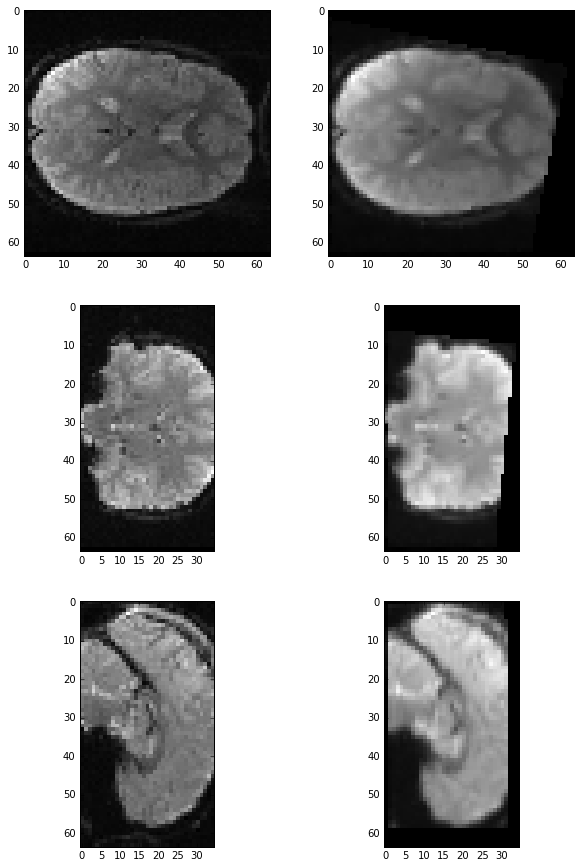

In [19]:
# - slices on z, y, and x axis from 
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes[0, 0].imshow(vol0[:, :, 17])
axes[0, 1].imshow(best_vol0[:, :, 17])
axes[1, 0].imshow(vol0[:, 31, :])
axes[1, 1].imshow(best_vol0[:, 31, :])
axes[2, 0].imshow(vol0[31, :, :])
axes[2, 1].imshow(best_vol0[31, :, :])

If you like, you can check in the file `make_rotated.py` to see what rotation I actually applied.

## If you raced ahead

Why not try another mismatch function?

And / or try another `fmin_` function from `scipy.optimize`?

Is it easy for the optimization to go wrong, or is it nearly always right whatever parameter you choose?